In [1]:
#install kaggle lib
!pip install kaggle

In [2]:
# Create the ~/.kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json from the input directory to ~/.kaggle/
!cp /kaggle/input/json-file14/kaggle.json ~/.kaggle/

# Set the correct permissions
!chmod 600 ~/.kaggle/kaggle.json

print("FINISH JSON")


FINISH JSON


In [3]:
!kaggle competitions download -c dogs-vs-cats

 98%|████████████████████████████████████████▏| 796M/812M [00:03<00:00, 290MB/s]
100%|█████████████████████████████████████████| 812M/812M [00:03<00:00, 259MB/s]


In [4]:
!ls

dogs-vs-cats.zip


In [5]:
#extracting data from compressed
from zipfile import ZipFile
dataset = "/kaggle/working/dogs-vs-cats.zip"
with ZipFile(dataset, "r") as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [6]:
#extracting data from compressed
from zipfile import ZipFile
dataset = "/kaggle/working/train.zip"
with ZipFile(dataset, "r") as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [7]:
#extracting data from compressed
dataset = "/kaggle/working/test1.zip"
with ZipFile(dataset, "r") as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [8]:
import os
# counting num of files in train folder
path, dirs, files = next(os.walk("/kaggle/working/train"))
file_count = len(files)
print("num of training files : ",file_count)

num of training files :  25000


In [9]:
train_file_names = os.listdir("/kaggle/working/train")
# print(train_file_names)

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

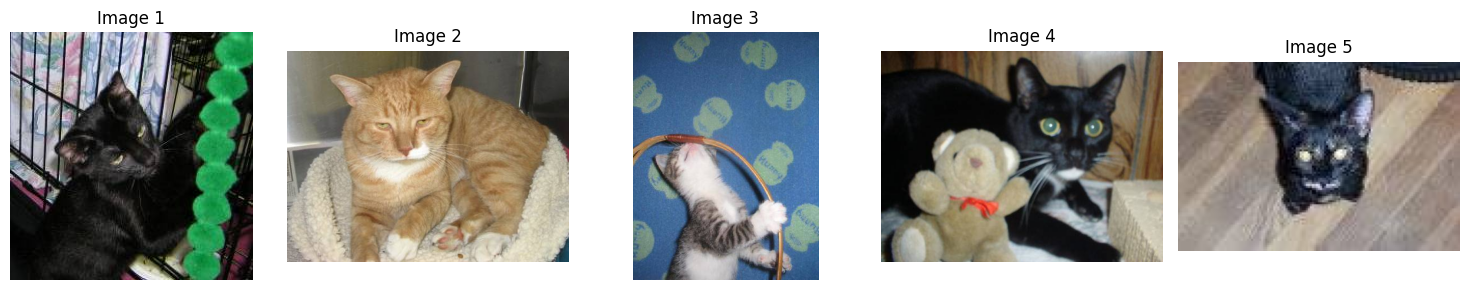

In [11]:
# List all files in the training directory
train_file_names = os.listdir("/kaggle/working/train")

# Create a figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1 row, 5 columns

# Plot the first 5 images
for i, ax in enumerate(axes):
    img = mpimg.imread("/kaggle/working/train/" + train_file_names[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(f"Image {i+1}")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [12]:
train_file_names = os.listdir("/kaggle/working/train/")

dog_count = 0
cat_count = 0
for img in range(len(train_file_names)):
  name = train_file_names[img]
  if name[0:3] == "dog":
    dog_count += 1
  elif name[0:3] == "cat":
    cat_count += 1
print("num of dogs : ",dog_count)
print("num of cats : ",cat_count)

num of dogs :  12500
num of cats :  12500


In [13]:
import os

# Check if the directory already exists
if not os.path.exists("/kaggle/working/resized_img"):
    # Create the directory if it doesn't exist
    os.mkdir("/kaggle/working/resized_img")
else:
    # Print a message if the directory already exists
    print("Directory '/kaggle/working/resized_img' already exists.")

In [14]:
import os
from PIL import Image

# Directories
train_dir = "/kaggle/working/train"  # Source directory with original images
resized_dir = "/kaggle/working/resized_img"  # Destination directory for resized images

# Ensure the resized directory exists
os.makedirs(resized_dir, exist_ok=True)

# Get a list of all image file names in the train directory
train_file_names = os.listdir(train_dir)

# Loop through each image file in the training directory
for img_name in train_file_names:
    img_path = os.path.join(train_dir, img_name)  # Full path to the image

    try:
        # Open, resize, and save the image
        img = Image.open(img_path)
        img = img.resize((120, 120))  # Resize to 120x120
        img.save(os.path.join(resized_dir, img_name))  # Save to resized directory
    except Exception as e:
        print(f"Error processing {img_name}: {e}")


In [15]:
# List all files in the resized directory
resized_train_file_names = os.listdir(resized_dir)

# Get the count of resized files
print(f"Number of resized images: {len(resized_train_file_names)}")


Number of resized images: 25000


In [16]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from matplotlib import cm
import glob


In [17]:
# Load Data
resized_dir = "/kaggle/working/resized_img"  # Path to resized images
img_extention = ['png', 'jpg']
files = []

# Collect all image files
[files.extend(glob.glob(resized_dir + "/*." + e)) for e in img_extention]

# Load images and labels
dog_cat_img = np.asarray([cv2.imread(file) for file in files]) / 255.0  # Normalize to [0, 1]
labels = np.array([1 if "dog" in file else 0 for file in files])  # 1 for dog, 0 for cat

# Split into train, validation, and test sets (70-15-15 split)
x_train, x_temp, Y_train, Y_temp = train_test_split(dog_cat_img, labels, test_size=0.3, random_state=42)
x_val, x_test, Y_val, Y_test = train_test_split(x_temp, Y_temp, test_size=0.5, random_state=42)

print("Data Shapes:")
print(f"Training: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")


Data Shapes:
Training: (17500, 120, 120, 3), Validation: (3750, 120, 120, 3), Test: (3750, 120, 120, 3)


In [18]:
# Compute Class Weights for Balancing
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")


Class Weights: {0: 1.0014879249170197, 1: 0.9985164897866028}


In [19]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)


In [20]:
# Transfer Learning with MobileNetV2
base_model = MobileNetV2(input_shape=(120, 120, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])



<ipython-input-20-e76f71b3972a>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(120, 120, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# model.summary()

In [22]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Train the model
history = model.fit(
    datagen.flow(x_train, Y_train, batch_size=32),
    validation_data=(x_val, Y_val),
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


547/547 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.8601 - loss: 0.3188 - precision: 0.8650 - recall: 0.8573 - val_accuracy: 0.9320 - val_loss: 0.1714 - val_precision: 0.9531 - val_recall: 0.9090 - learning_rate: 0.0010
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 56s 100ms/step - accuracy: 0.9016 - loss: 0.2275 - precision: 0.9064 - recall: 0.8948 - val_accuracy: 0.9251 - val_loss: 0.1805 - val_precision: 0.8987 - val_recall: 0.9585 - learning_rate: 0.0010
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accuracy: 0.9006 - loss: 0.2198 - precision: 0.9072 - recall: 0.8946 - val_accuracy: 0.9312 - val_loss: 0.1626 - val_precision: 0.9133 - val_recall: 0.9532 - learning_rate: 0.0010
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 56s 100ms/step - accuracy: 0.9096 - loss: 0.2067 - precision: 0.9142 - recall: 0.9049 - val_accuracy: 0.9341 - val_loss: 0.1676 - val_precision: 0.9096 - val_recall: 0.9643 - learning_rate: 0.0010
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accura

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9390 - loss: 0.1496 - precision: 0.9231 - recall: 0.9550
Test Loss: 0.14799141883850098, Test Accuracy: 0.9383999705314636, Precision: 0.9311075806617737, Recall: 0.9456404447555542


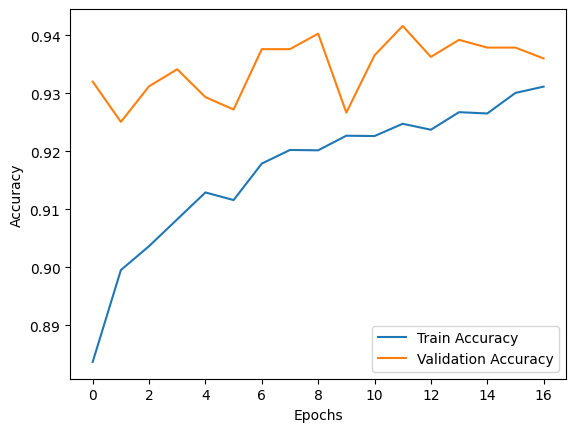

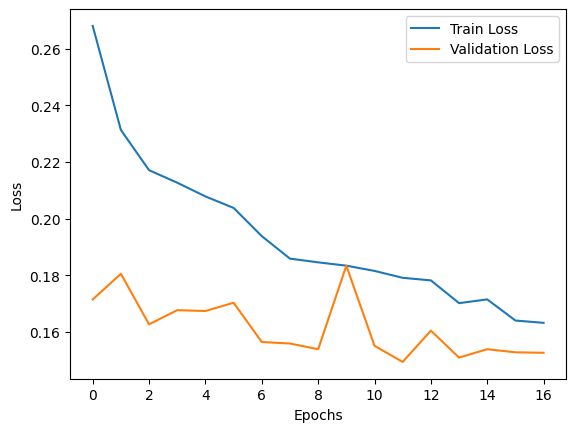

In [23]:
# Evaluate the model
score, acc, prec, rec = model.evaluate(x_test, Y_test)
print(f"Test Loss: {score}, Test Accuracy: {acc}, Precision: {prec}, Recall: {rec}")

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


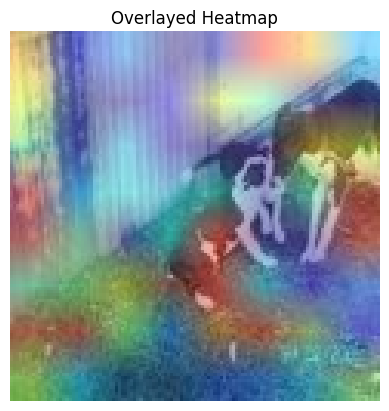

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Grad-CAM Function
def grad_cam(model, img_array, last_conv_layer_name):
    """
    Generate a heatmap using Grad-CAM to show where the model focuses during prediction.
    Arguments:
    - model: Trained model
    - img_array: Preprocessed input image (batch of size 1)
    - last_conv_layer_name: Name of the last convolutional layer
    
    Returns:
    - heatmap: The heatmap of the focused area
    """
    # Create a model that maps the input image to the activations of the last conv layer and the output
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=[model.input],  # Use model input directly
        outputs=[last_conv_layer.output, model.output]  # Last convolution layer and model output
    )
    
    # Record gradients with respect to the model's output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Assume binary classification (0 or 1)

    # Compute the gradient of the loss with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients across all the axes (height, width)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the mean gradient
    conv_outputs = conv_outputs[0]  # Get the feature map for the first image in the batch
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Apply ReLU to the heatmap (ignore negative values)
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Overlay Heatmap Function
def overlay_heatmap(heatmap, original_image, alpha=0.4, colormap=plt.cm.jet):
    """
    Overlay the heatmap on the original image.
    Arguments:
    - heatmap: Grad-CAM heatmap to overlay
    - original_image: Original input image (RGB)
    - alpha: Transparency level of the heatmap
    - colormap: Colormap for the heatmap
    
    Returns:
    - overlayed_image: Image with heatmap overlayed
    """
    # Resize the heatmap to the size of the original image
    heatmap = np.uint8(255 * heatmap)  # Rescale heatmap to [0, 255]
    heatmap_colored = colormap(heatmap)  # Apply colormap
    heatmap_colored = np.delete(heatmap_colored, 3, axis=-1)  # Remove alpha channel

    # Resize to match original image size
    heatmap_colored = cv2.resize(heatmap_colored, (original_image.shape[1], original_image.shape[0]))

    # Overlay the heatmap on the original image
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

# Example of using Grad-CAM
input_img = x_test[0:1]  # Select one test image (batch of size 1)
heatmap = grad_cam(model, input_img, 'block_13_expand')  # 'block_13_expand' is the last convolution layer in MobileNetV2

# Overlay heatmap on the original image
overlayed_image = overlay_heatmap(heatmap, x_test[0])  # Original image

# Display the overlayed image with the heatmap
plt.imshow(overlayed_image)
plt.title("Overlayed Heatmap")
plt.axis('off')
plt.show()


In [25]:
# Save Model
model.save("dog_vs_cat_classifier.h5")
print("Model saved as 'dog_vs_cat_classifier.h5'")


Model saved as 'dog_vs_cat_classifier.h5'


118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1892
           1       0.93      0.95      0.94      1858

    accuracy                           0.94      3750
   macro avg       0.94      0.94      0.94      3750
weighted avg       0.94      0.94      0.94      3750

Precision: 0.9311
Recall: 0.9456
F1-Score: 0.9383


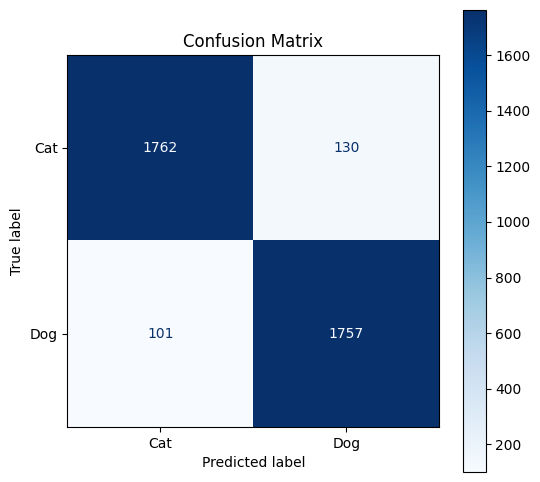

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = (model.predict(x_test) > 0.5).astype(int)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

# Print the classification report
print("Classification Report:\n", classification_report(Y_test, y_pred))

# Print the individual metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Enter the path of the image:  /kaggle/input/test-img/cat.jpg


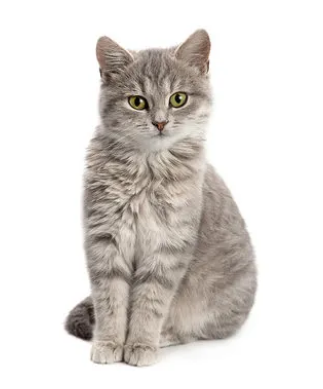

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Raw Model output (probabilities): [[0.00035319]]
The image is a cat


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os

# Function to process and predict an image
def predict_image(input_img_path, model, threshold=0.5):
    try:
        # Check if the image path exists
        if not os.path.exists(input_img_path):
            print(f"Error: The image path {input_img_path} does not exist.")
            return

        # Read the image
        input_img = cv2.imread(input_img_path)

        # Show the original image using matplotlib
        # Convert BGR (OpenCV default) to RGB (for matplotlib)
        input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        plt.imshow(input_img_rgb)
        plt.axis('off')  # Hide axes
        plt.show()

        # Resize the image to match the model input size (120x120)
        input_img_resize = cv2.resize(input_img, (120, 120))

        # Normalize the image using MobileNetV2's preprocess_input function
        input_img_scaled = preprocess_input(input_img_resize.astype(np.float32))  # For pre-trained models

        # Reshape the image to match the input shape for the model (1, 120, 120, 3)
        input_img_reshape = np.expand_dims(input_img_scaled, axis=0)

        # Predict using the model
        input_prediction = model.predict(input_img_reshape)

        # Print the prediction output
        print(f"Raw Model output (probabilities): {input_prediction}")

        # Use a threshold to make the final decision
        input_pred_label = (input_prediction >= threshold).astype(int)[0][0]

        # Output the result based on the predicted label
        if input_pred_label == 0:
            print("The image is a cat")
        else:
            print("The image is a dog")

    except Exception as e:
        print(f"An error occurred: {e}")

# Get the image path from user input
input_img_path = input("Enter the path of the image: ")

# Perform prediction with a threshold of 0.5
predict_image(input_img_path, model, threshold=0.5)
